In [1]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy import special as spf
from scipy.special import roots_legendre

import SSLimPy.interface.config as cfg

from SSLimPy.interface import sslimpy
from SSLimPy.LIMsurvey import covariance
from SSLimPy.LIMsurvey import power_spectrum
from SSLimPy.LIMsurvey import higher_order
from SSLimPy.utils import utils as utl

In [2]:
envkey = "OMP_NUM_THREADS"
# Set this environment variable to the number of available cores in your machine,
# to get a fast execution of the Einstein Boltzmann Solver
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))
os.environ[envkey] = str(12)
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))

The value of OMP_NUM_THREADS is:  None
The value of OMP_NUM_THREADS is:  12


In [3]:
cosmodict = {"h": 0.68, "Omegam": 0.3, "Omegab": 0.04, "As": 2.1e-9, "mnu": 0.06}
settings = {"code":"class",
            "do_RSD" : True,
            "nonlinearRSD" : True,
            "FoG_damp" : "ISTF_like",
            "halo_model_PS" : True,
            "Smooth_window" : False,
            "nk":100,
            "kmax": 50*u.Mpc**-1,
            "kmin": 1e-3*u.Mpc**-1,
            }
halopars = {
    "hmf_model":"sc_hmf",
    "bias_model": "b1",
    "nR" : 256,
}

astrodict = {
    "model_type":"ML",
    "model_name":"MassPow",
    "model_par": {
        "A":2e-6,
        "b":1,
    },
}
Asslimpy = sslimpy.sslimpy(settings_dict=settings, cosmopars=cosmodict, astropars=astrodict)
pobs = power_spectrum.PowerSpectra(Asslimpy.fiducialastro)

  █████   █████  █       █            █████   █    █ 
 █     █ █     █ █            █   █   █    █  █   █  
 █       █       █     ███   █ █ █ █  █    █   █ █   
  █████   █████  █       █   █  █  █  █████     █    
       █       █ █       █   █     █  █        █     
 █     █ █     █ █       █   █     █  █       █      
  █████   █████  █████ █████ █     █  █      █       

#---------------------------------------------------#


In [4]:
ng = covariance.nonGuassianCov(pobs)

In [5]:
k = ng.k
z = ng.z
Pk = ng.cosmo.matpow(k, z, nonlinear="False", tracer=ng.tracer)

xi, w = roots_legendre(cfg.settings["nnodes_legendre"])
mu = np.pi * xi

kl = len(k)
wl = len(w)

# compute I1 for v_of_M models
I1 = np.empty((kl, wl))
indexmenge = range(wl)
for imu1 in indexmenge:
    Ii = ng.astro.Lhalo(
        z, k, mu[imu1], p=1
    )
    I1[:, imu1] = Ii.value

Lmb1 = ng.astro.bavg("b1", z, 1)
Lmb2 = ng.astro.bavg("b2", z, 1)
LmbG2 = ng.astro.bavg("bG2", z, 1)
Lmb3 = ng.astro.bavg("b3", z, 1)
LmbdG2 = ng.astro.bavg("bdG2", z, 1)
LmbG3 = ng.astro.bavg("bG3", z, 1)
LmbDG2 = ng.astro.bavg("bDG2", z, 1)
f = ng.cosmo.growth_rate(1e-3 * u.Mpc**-1, z, tracer=ng.tracer)

k, Pk = k.value, Pk.value

mu1, ph1 = 0.2, 0.1
mu2, ph2 = 0.2, 0.1

T = np.empty((*k.shape, *k.shape))
for ik1, k1 in enumerate(k):
    for ik2, k2 in enumerate(k):
        T = higher_order.TrispectrumL0(Lmb1, Lmb2, LmbG2, Lmb3, LmbdG2, LmbG3, LmbDG2, f.item(),
                                       k1, mu1, ph1, k1, -mu1, ph1+np.pi, k2, mu2, ph2, k, Pk)

In [6]:
T0 = ng.integrate_4h()

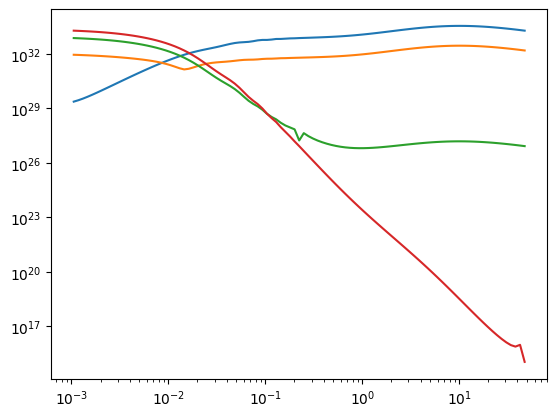

In [11]:
plt.loglog(k, T0[:,0,0,0])
plt.loglog(k, T0[:,24,0,0])
plt.loglog(k, T0[:,49,0,0])
plt.loglog(k, T0[:,98,0,0])

In [7]:
M = pobs.astro.M
z = 0

b1 = pobs.halomodel._bias_function.b1(M, z, 1.68)
b2 = pobs.halomodel._bias_function.b2(M, z, 1.68)
b3 = pobs.halomodel._bias_function.b3(M, z, 1.68)

(-3.0, 5.0)

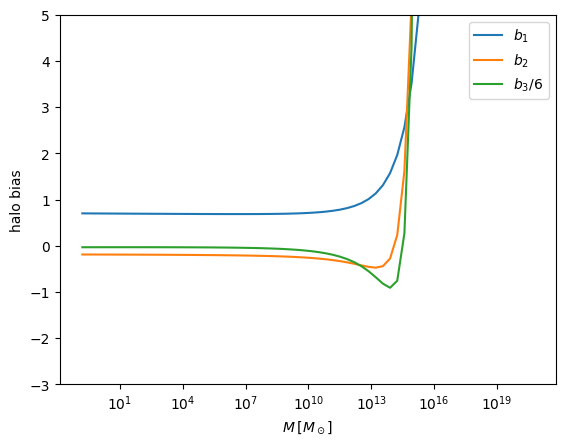

In [8]:
plt.semilogx(M, b1, label="$b_1$")
plt.semilogx(M, b2, label="$b_2$")
plt.semilogx(M, b3/6, label="$b_3/6$")
plt.xlabel(r"$M \:[M_\odot]$")
plt.ylabel("halo bias")
plt.legend()
plt.ylim((-3,5))


Text(0, 0.5, '$M^3$ $\\times$ halo bias $\\times$ HMF $[M_\\odot^2\\,\\mathrm{Mpc}^{-3}]$')

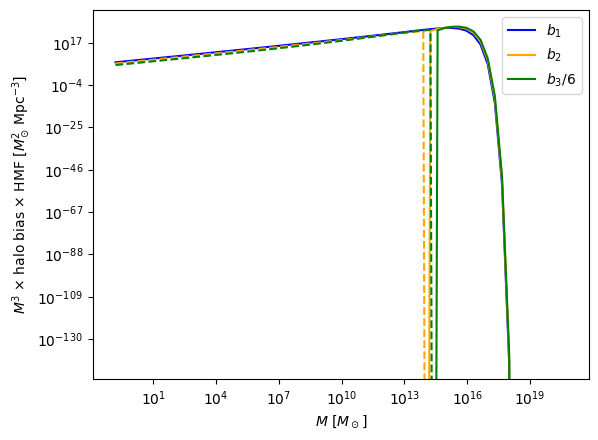

In [14]:
dndM = pobs.halomodel.halomassfunction(M, z)
#dndM.shape
plt.loglog(M,M**3 * b1 * dndM, c="blue", label="$b_1$")
plt.loglog(M,M**3 * b2 * dndM, c="orange", label="$b_2$")
plt.loglog(M,M**3 *-b2 * dndM, ls="--", c="orange")
plt.loglog(M,M**3 * (b3/6) * dndM, c="green", label="$b_3/6$")
plt.loglog(M,M**3 *-(b3/6) * dndM, ls="--",c="green")
plt.legend()
plt.xlabel(r"$M$ $[M_\odot]$")
plt.ylabel(r"$M^3$ $\times$ halo bias $\times$ HMF $[M_\odot^2\,\mathrm{Mpc}^{-3}]$")
